In [1]:
import jax.random
from jax.config import config

config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import block_until_ready
import numpy as onp

from tox.objects import Box
from tox.utils import discretize_dynamics
from tox.solvers import leqg

import time as clock
import matplotlib.pyplot as plt


def final_cost(state: jnp.ndarray, goal_state: jnp.ndarray) -> float:
    final_state_cost = jnp.diag(jnp.array([1e1, 1e0]))
    c = 0.5 * (state - goal_state).T @ final_state_cost @ (state - goal_state)
    return c


def transient_cost(
    state: jnp.ndarray, action: jnp.ndarray, time: int, goal_state: jnp.ndarray
) -> float:
    state_cost = jnp.diag(jnp.array([1e1, 1e0]))
    action_cost = jnp.diag(jnp.array([1e0]))

    c = 0.5 * (state - goal_state).T @ state_cost @ (state - goal_state)
    c += 0.5 * action.T @ action_cost @ action
    return c


def double_integrator(
    state: jnp.ndarray, action: jnp.ndarray, time: int
) -> jnp.ndarray:
    A = jnp.array([[0.0, 1.0], [0.0, 0.0]])
    B = jnp.array([[0.0], [1.0]])
    c = jnp.array([0.0, 0.0])
    return A @ state + B @ action + c


simulation_step = 0.01
downsampling = 10
dynamics = discretize_dynamics(
    ode=double_integrator,
    simulation_step=simulation_step,
    downsampling=downsampling,
)

state_dim = 2
action_dim = 1

state_space: Box = Box(
    low=jnp.ones((state_dim,)) * jnp.finfo(jnp.float64).min,
    high=jnp.ones((state_dim,)) * jnp.finfo(jnp.float64).max,
    shape=(state_dim,),
)

action_space: Box = Box(
    low=jnp.ones((action_dim,)) * jnp.finfo(jnp.float64).min,
    high=jnp.ones((action_dim,)) * jnp.finfo(jnp.float64).max,
    shape=(action_dim,),
)

init_state = jnp.array([0.0, 0.0])
goal_state = jnp.array([10.0, 0.0])
horizon = 100
noise_var = 1e-2
key = jax.random.PRNGKey(1337)

In [2]:
# input_indx = [-1, -0.5, 0, 0.5, 1]
risk_params = onp.arange(start=-1, stop=1, step=0.05)
# risk_params = onp.array([-10,-5,-2,-1,0,1,2,5,10])
param_num = risk_params.shape[0]

all_states = onp.zeros(shape=(horizon+1,2,param_num))
all_inputs = onp.zeros(shape=(horizon,param_num))
all_costs = onp.zeros(shape=(param_num,))


for ind, val in enumerate(risk_params):
    start = clock.time()

    policy = leqg.solver(
        final_cost,
        transient_cost,
        dynamics,
        state_space,
        action_space,
        val,         # risk_param
        noise_var,   # noise_var
        goal_state,
        horizon,
    )
    episode = leqg.rollout(
        key,
        final_cost,
        transient_cost,
        dynamics,
        state_space,
        action_space,
        policy,
        init_state,
        goal_state,
        horizon,
    )
    block_until_ready(episode)
    end = clock.time()
    print("== ",ind)
    print("risk_param:",val)
    print("Compilation + Execution Time:", end - start)  
    state, action, total_cost = episode
    all_states[:,:,ind] = onp.copy(state)
    all_inputs[:,ind] = onp.copy(onp.squeeze(action))
    all_costs[ind] = onp.copy(total_cost)
    print("---")

==  0
risk_param: -1.0
Compilation + Execution Time: 2.4407973289489746
---
==  1
risk_param: -0.95
Compilation + Execution Time: 0.0014908313751220703
---
==  2
risk_param: -0.8999999999999999
Compilation + Execution Time: 0.0005459785461425781
---
==  3
risk_param: -0.8499999999999999
Compilation + Execution Time: 0.0005309581756591797
---
==  4
risk_param: -0.7999999999999998
Compilation + Execution Time: 0.0004980564117431641
---
==  5
risk_param: -0.7499999999999998
Compilation + Execution Time: 0.00049591064453125
---
==  6
risk_param: -0.6999999999999997
Compilation + Execution Time: 0.0004940032958984375
---
==  7
risk_param: -0.6499999999999997
Compilation + Execution Time: 0.0005018711090087891
---
==  8
risk_param: -0.5999999999999996
Compilation + Execution Time: 0.0004737377166748047
---
==  9
risk_param: -0.5499999999999996
Compilation + Execution Time: 0.0004744529724121094
---
==  10
risk_param: -0.49999999999999956
Compilation + Execution Time: 0.0005385875701904297
--

In [3]:
import matplotlib.animation
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# ----

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
#plt.style.use("dark_background")
params = {"text.color" : "white",
          "xtick.color" : "white",
          "ytick.color" : "white",
          "axes.facecolor": "#bfbfbf", 
          "figure.facecolor": "None"}
text_kwargs = dict(ha='center', va='center', fontsize=12, color='#1231ff')
plt.rcParams.update(params)
plt.ioff()

fig = plt.figure(figsize=(16, 7))

axs = [fig.add_subplot(2, 2, i+1) for i in range(4)]

input_indx = [0,1,2]
input_lines = onp.squeeze([axs[ind].plot([], [], '-', lw=1) for ind in input_indx])

risk_param_text = axs[3].text(0.5, 0.5, '', transform=axs[3].transAxes, **text_kwargs)
axs[0].set_title("x1")
axs[1].set_title("x2")
axs[2].set_title("u")
axs[3].set_xticks([], [])
axs[3].set_yticks([], [])
for i in range(3):
    axs[i].grid()


In [4]:
t = onp.linspace(start=0, stop=horizon, num=horizon)
t1 = onp.linspace(start=0, stop=horizon+1, num=horizon+1)

def animate(i, *axs):
    msg_text = "Risk Param: \n" + str(risk_params[i]) + "\n Total cost: \n" + str(all_costs[i])
    risk_param_text.set_text(msg_text)
    thisx = t1 

    thisy = all_states[:,0,i]
    input_lines[0].set_data(thisx,thisy)
    # axs[0].set_ylim([min(thisy)-0.2*abs(min(thisy)), 1.2*max(thisy)])
    axs[0].set_xlim([-2, horizon+2])    
    axs[0].set_ylim([onp.nanmin(thisy)-0.2*abs(onp.nanmin(thisy)), 1.2*onp.nanmax(thisy)])
    thisy = all_states[:,1,i]
    input_lines[1].set_data(thisx,thisy)
    # axs[1].set_ylim([min(thisy)-0.2*abs(min(thisy)), 1.2*max(thisy)])
    axs[1].set_xlim([-2, horizon+2])    
    axs[1].set_ylim([onp.nanmin(thisy)-0.2*abs(onp.nanmin(thisy)), 1.2*onp.nanmax(thisy)])

    thisx = t
    thisy = all_inputs[:,i]
    input_lines[2].set_data(thisx,thisy)
    # axs[2].set_ylim([min(thisy)-0.2*abs(min(thisy)), 1.2*max(thisy)])
    axs[2].set_xlim([-2, horizon+2])
    nanmin = onp.nanmin(thisy)
    nanmax = onp.nanmax(thisy)
    if onp.isnan(nanmin) or onp.isnan(nanmax):
        nanmin = 0
        nanmax = 1

    axs[2].set_ylim([nanmin-0.2*abs(nanmin), 1.2*nanmax])
    

    plt.tight_layout()
    return input_lines
    

#----
matplotlib.animation.FuncAnimation(fig, animate, param_num, fargs=axs, interval=1000, blit=True) # iter_num

<Figure size 2400x1050 with 0 Axes>

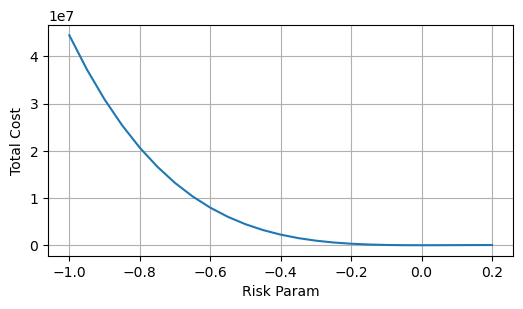

In [5]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig.clf()
fig = plt.figure(figsize=(6, 3))
axs = fig.add_subplot(1, 1, 1)
axs.plot(risk_params,all_costs)
axs.set_xlabel("Risk Param")
axs.set_ylabel("Total Cost")
axs.grid()
plt.show()